In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 
from sklearn.mixture import GaussianMixture

import pylab as pl
from time import sleep
import tensorflow as tf
#import tensorflow_probability as tfp
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)
size = 5
pre_smoothing = False
conv = True
sigma = 0.1


import logging
tf.get_logger().setLevel(logging.ERROR)

2023-05-24 02:33:15.212194: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 02:33:15.370329: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-05-24 02:33:15.370372: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-24 02:33:15.992644: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerr

# Fitting differential operator

In [14]:
def augment(yx, crop=256, do_flips=True, do_rotate=True, do_scale=True):
    
    if do_flips:
        if np.random.uniform(0,1) > 0.5:
            if np.random.uniform(0,1) > 0.5:
                for i in range(len(yx)):
                    yx[i] = cv2.flip(yx[i],0)
            else:
                for i in range(len(yx)):
                    yx[i] = cv2.flip(yx[i],1)
 

    ch, cw = yx[0].shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((cw/2,ch/2),np.random.rand()*360*float(do_rotate),
                            1+float(do_scale)*(np.random.uniform(-0.2,0.2)))
    for i in range(len(yx)):
        yx[i] = cv2.warpAffine(yx[i],rotation_matrix, (ch,cw),cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    
    return yx
    
N_REPEAT_FRAME = 1

def sample_images(frame_nums):
    while True:
        try:
            var = np.random.randint(var_d,var_u)
            img = open_frame(np.random.choice(frame_nums),var,CROP)
        except Exception as e:
            print(f'Exception {e} on file')
            continue        
            
        for n in range(N_REPEAT_FRAME):
            
            a =  augment(np.copy(img),crop = CROP)
            yield a
            
def get_data_generator(sampler):
    def get_data():
        while True:
            yx = next(sampler)
            
            x,y = yx[1],yx[0]
            y = np.sum(np.array(np.gradient(y))**2,axis=0)
            y = np.asarray(y>np.percentile(y,80),dtype='float')
            
            x = np.expand_dims(x,axis=-1)
            y = np.expand_dims(y,axis=-1)
            
            yield x,y
                    
    return get_data

test = glob('../../images/test/*.jpg')
train = glob('../../images/train/*.jpg')

In [53]:
BATCH_SIZE = 5
var_d=0
var_u=100

dg_train = tf.data.Dataset.from_generator(
    get_data_generator(sample_images(train)),
    output_types=(tf.float32, tf.float32),
    output_shapes=((CROP, CROP, 1),(CROP, CROP, 1)) )

dg_val = tf.data.Dataset.from_generator(
    get_data_generator(sample_images(test)),
    output_types=(tf.float32, tf.float32),
    output_shapes=((CROP, CROP, 1),(CROP, CROP, 1)) )

gen_batch_train = dg_train.batch(BATCH_SIZE)
gen_batch_val = dg_val.batch(BATCH_SIZE)

In [54]:
xs, ys = next(gen_batch_val.as_numpy_iterator())

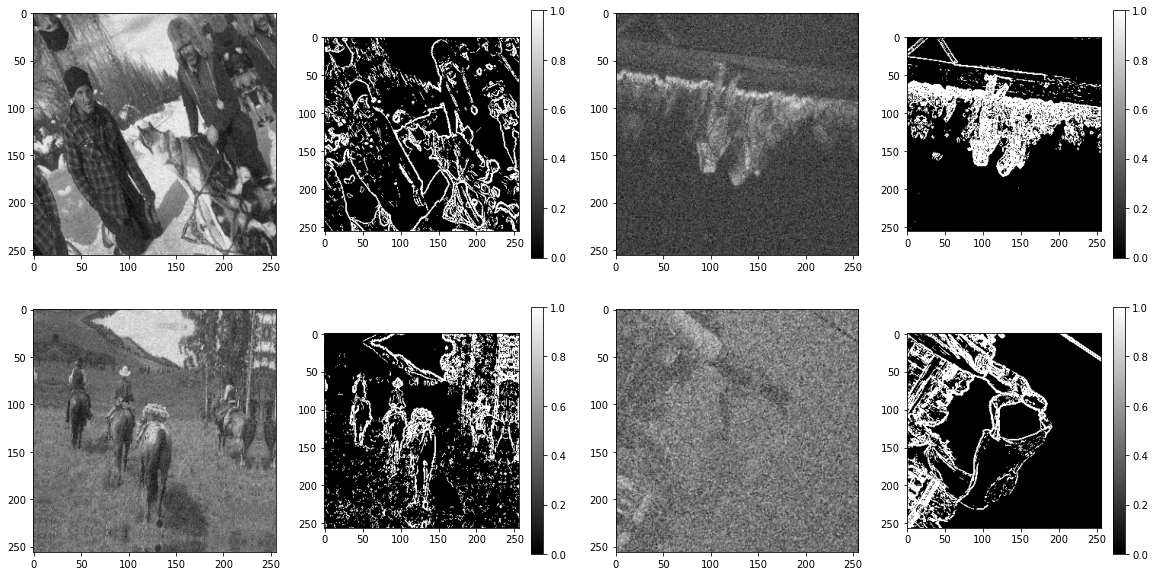

In [55]:
nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs))
        axs[i,2*j].imshow(np.squeeze(xs[_]),cmap='gray')
        im = axs[i,2*j+1].imshow(np.squeeze(ys[_]),cmap='gray')
        plt.colorbar(im,ax=axs[i,2*j+1])
        
plt.show()

In [50]:
factor1 = 0.001
degree = 1
num_filters = np.sum(2**np.arange(1,degree+1))

def constraint(W):
    or_shape = W.shape
    shift = (2*degree+2)*((2*degree+1)//2)
    NW = []
    for w in tf.unstack(W,axis=-1):
        nw = tf.roll(tf.reshape(w,[(2*degree+1)**2]),shift=shift+1,axis=0)
        nw = tf.slice(nw,[1],[(2*degree+1)**2-1])
        nw = tf.abs(nw)
        center = -tf.expand_dims(tf.reduce_sum(nw),0)
        nw = tf.concat((center,nw),axis=0)
        nw = tf.roll(nw,shift,axis=0)
        nw = tf.reshape(nw,(2*degree+1,2*degree+1,1))
        NW.append(nw)
        
    NW = tf.stack(NW,axis=-1)
        
    return NW

def regularizer(w):

    projections = tf.unstack(w,axis=-1)
    initial = 0

    for pr in range(len(projections)):
        for ps in range(len(projections)):
            if pr > ps:
                proj = tf.multiply(projections[pr],projections[ps])
                initial += tf.reduce_sum(tf.abs(proj)) - tf.reduce_sum(tf.abs(proj[degree,degree]))
                

    
    return factor1 * initial


input_shape = image_size + (1,)
inputs = tf.keras.Input(shape=input_shape,name='input')

#x = tf.keras.layers.Conv2D(num_filters,(2*degree+1,2*degree+1),padding='same',use_bias=False,
#                        kernel_constraint=constraint,kernel_regularizer = regularizer, name='diff')(inputs)
x = tf.keras.layers.Conv2D(num_filters,(2*degree+1,2*degree+1),padding='same')(inputs)
diff_op1 = tf.keras.layers.Lambda(lambda z: tf.pow(z,2))(x)
diff_op = tf.keras.layers.Conv2D(1,1,padding='same',name='no_train',activation='sigmoid')(diff_op1)


model = tf.keras.models.Model(inputs, diff_op)
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 256, 256, 2)       20        
                                                                 
 lambda_8 (Lambda)           (None, 256, 256, 2)       0         
                                                                 
 no_train (Conv2D)           (None, 256, 256, 1)       3         
                                                                 
Total params: 23
Trainable params: 23
Non-trainable params: 0
_________________________________________________________________


In [51]:
def loss(y_true,y_pred):
    return tf.reduce_mean(tf.multiply(tf.exp(y_true)-1,tf.pow(y_true-y_pred,2)))

model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),loss=tf.keras.losses.BinaryCrossentropy(
    from_logits=False,
)
)
history = model.fit(
            gen_batch_train,
            epochs=20,
            steps_per_epoch=100,
            validation_data=gen_batch_val,
            validation_steps=10,
            shuffle=False,
            callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1,patience=5)],
            use_multiprocessing=True,
            workers=1
        )

Epoch 1/20
100/100 [==============================] - 6s 60ms/step - loss: 0.5924 - val_loss: 0.5168 - lr: 0.0100
Epoch 2/20
100/100 [==============================] - 6s 60ms/step - loss: 0.4734 - val_loss: 0.4349 - lr: 0.0100
Epoch 3/20
100/100 [==============================] - 6s 58ms/step - loss: 0.4298 - val_loss: 0.4154 - lr: 0.0100
Epoch 4/20
100/100 [==============================] - 6s 57ms/step - loss: 0.4155 - val_loss: 0.4143 - lr: 0.0100
Epoch 5/20
100/100 [==============================] - 6s 56ms/step - loss: 0.4080 - val_loss: 0.4069 - lr: 0.0100
Epoch 6/20
100/100 [==============================] - 6s 56ms/step - loss: 0.4150 - val_loss: 0.3999 - lr: 0.0100
Epoch 7/20
100/100 [==============================] - 6s 56ms/step - loss: 0.4149 - val_loss: 0.4055 - lr: 0.0100
Epoch 8/20
100/100 [==============================] - 6s 56ms/step - loss: 0.4118 - val_loss: 0.4092 - lr: 0.0100
Epoch 9/20
100/100 [==============================] - 6s 56ms/step - loss: 0.4164 - val_

KeyboardInterrupt: 

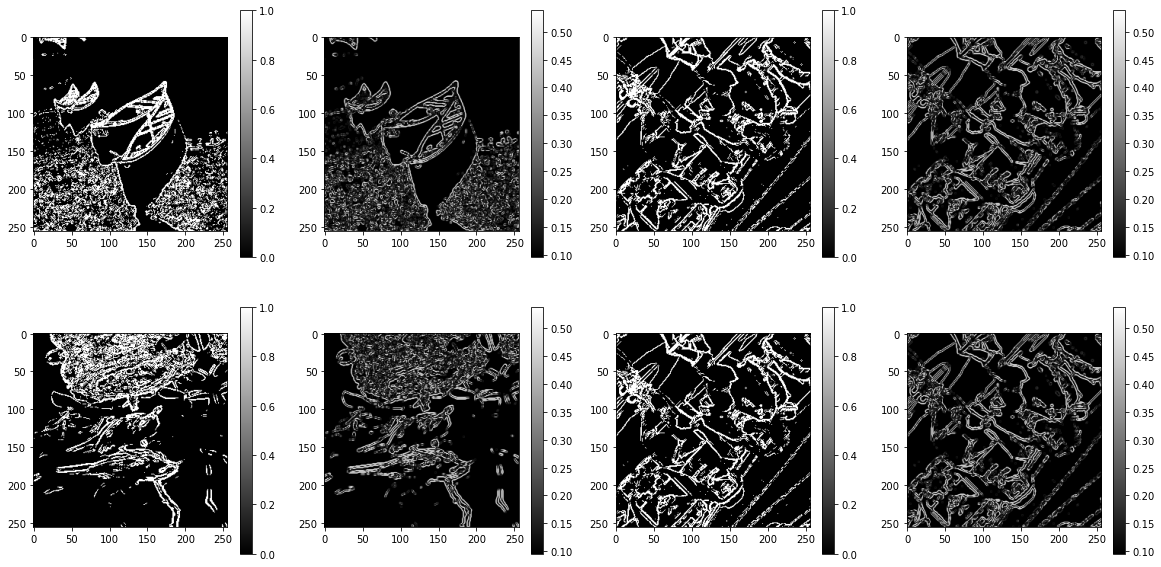

In [52]:
xs, ys = next(gen_batch_val.as_numpy_iterator())
p = model(ys)

nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs))
        im = axs[i,2*j].imshow(np.squeeze(ys[_]),cmap='gray')
        plt.colorbar(im,ax=axs[i,2*j])
        im = axs[i,2*j+1].imshow(np.squeeze(p[_]),cmap='gray')
        plt.colorbar(im,ax=axs[i,2*j+1])
        
plt.show()

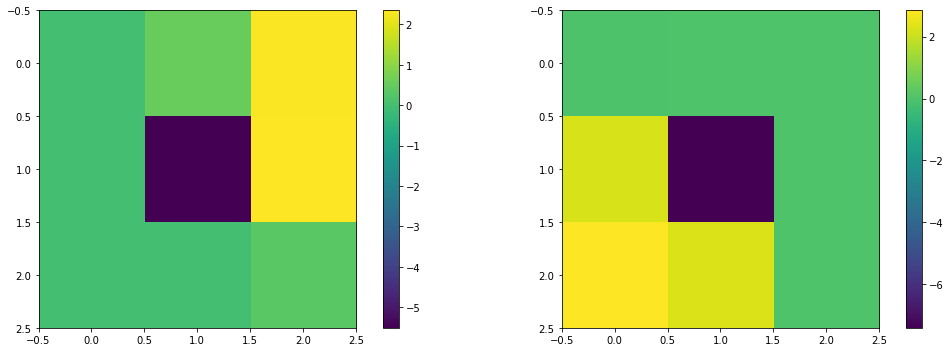

In [92]:
w = np.squeeze(model.layers[1].weights[0].numpy())

fig,axs = plt.subplots(ncols=w.shape[-1],figsize=(15,5))
for i in range(w.shape[-1]):
    im = axs[i].imshow(w[...,i])
    plt.colorbar(im,ax=axs[i])
    
plt.tight_layout()
plt.show()

In [ ]:
for degree in range(1,7):
    print(degree)
    
    num_filters = np.sum(2**np.arange(1,degree+1))
    
    input_shape = image_size + (1,)
    inputs = tf.keras.Input(shape=input_shape,name='input')

    x = tf.keras.layers.Conv2D(num_filters,(2*degree+1,2*degree+1),padding='same',use_bias=False,
                            kernel_constraint=constraint,kernel_regularizer = regularizer, name='diff')(inputs)
    diff_op1 = tf.keras.layers.Lambda(lambda z: tf.pow(z,2))(x)
    diff_op = tf.keras.layers.Conv2D(1,1,padding='same',name='no_train',activation='sigmoid')(diff_op1)


    model = tf.keras.models.Model(inputs, diff_op)
    
    
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),loss=tf.keras.losses.BinaryCrossentropy(
    from_logits=False,
    )
    )
    
    
    callbacks = [tf.keras.callbacks.ModelCheckpoint(
                filepath= f"./checkpoints/DifferentialClassifier_{degree}",
                save_weights_only=True,
                verbose = True,
                save_best_only=True),
                tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1,patience=5),
                tf.keras.callbacks.TerminateOnNaN()

                ]
    
    
    history = model.fit(
                gen_batch_train,
                epochs=20,
                steps_per_epoch=100,
                validation_data=gen_batch_val,
                validation_steps=10,
                shuffle=False,
                callbacks = callbacks,
                use_multiprocessing=True,
                workers=1
            )

1
Epoch 1/20
100/100 [==============================] - ETA: 0s - loss: 0.6019
Epoch 1: val_loss improved from inf to 0.52223, saving model to ./checkpoints/DifferentialClassifier_1
100/100 [==============================] - 7s 60ms/step - loss: 0.6019 - val_loss: 0.5222 - lr: 0.0100
Epoch 2/20
100/100 [==============================] - ETA: 0s - loss: 0.5053
Epoch 2: val_loss improved from 0.52223 to 0.49588, saving model to ./checkpoints/DifferentialClassifier_1
100/100 [==============================] - 6s 58ms/step - loss: 0.5053 - val_loss: 0.4959 - lr: 0.0100
Epoch 3/20
100/100 [==============================] - ETA: 0s - loss: 0.4971
Epoch 3: val_loss improved from 0.49588 to 0.49558, saving model to ./checkpoints/DifferentialClassifier_1
100/100 [==============================] - 6s 59ms/step - loss: 0.4971 - val_loss: 0.4956 - lr: 0.0100
Epoch 4/20
100/100 [==============================] - ETA: 0s - loss: 0.4966
Epoch 4: val_loss improved from 0.49558 to 0.49512, saving model


Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.
100/100 [==============================] - 7s 68ms/step - loss: 0.4953 - val_loss: 0.4904 - lr: 0.0020
Epoch 14/20
100/100 [==============================] - ETA: 0s - loss: 0.4940
Epoch 14: val_loss did not improve from 0.47200
100/100 [==============================] - 7s 67ms/step - loss: 0.4940 - val_loss: 0.4919 - lr: 4.0000e-04
Epoch 15/20
100/100 [==============================] - ETA: 0s - loss: 0.4931
Epoch 15: val_loss did not improve from 0.47200
100/100 [==============================] - 7s 67ms/step - loss: 0.4931 - val_loss: 0.4948 - lr: 4.0000e-04
Epoch 16/20
100/100 [==============================] - ETA: 0s - loss: 0.4932
Epoch 16: val_loss did not improve from 0.47200
100/100 [==============================] - 7s 67ms/step - loss: 0.4932 - val_loss: 0.4917 - lr: 4.0000e-04
Epoch 17/20
100/100 [==============================] - ETA: 0s - loss: 0.4927
Epoch 17: val_loss did not improve from 0.

100/100 [==============================] - ETA: 0s - loss: 0.5931
Epoch 5: val_loss improved from 0.65836 to 0.54438, saving model to ./checkpoints/DifferentialClassifier_4
100/100 [==============================] - 19s 193ms/step - loss: 0.5931 - val_loss: 0.5444 - lr: 0.0100
Epoch 6/20
100/100 [==============================] - ETA: 0s - loss: 0.5502
Epoch 6: val_loss did not improve from 0.54438
100/100 [==============================] - 19s 193ms/step - loss: 0.5502 - val_loss: 0.5545 - lr: 0.0100
Epoch 7/20
100/100 [==============================] - ETA: 0s - loss: 0.5510
Epoch 7: val_loss improved from 0.54438 to 0.51930, saving model to ./checkpoints/DifferentialClassifier_4
100/100 [==============================] - 19s 192ms/step - loss: 0.5510 - val_loss: 0.5193 - lr: 0.0100
Epoch 8/20
100/100 [==============================] - ETA: 0s - loss: 0.5353
Epoch 8: val_loss improved from 0.51930 to 0.51377, saving model to ./checkpoints/DifferentialClassifier_4
100/100 [===========

Epoch 17/20
100/100 [==============================] - ETA: 0s - loss: 0.6696
Epoch 17: val_loss improved from 0.51039 to 0.49953, saving model to ./checkpoints/DifferentialClassifier_5
100/100 [==============================] - 40s 399ms/step - loss: 0.6696 - val_loss: 0.4995 - lr: 0.0020
Epoch 18/20
100/100 [==============================] - ETA: 0s - loss: 0.5247
Epoch 18: val_loss did not improve from 0.49953
100/100 [==============================] - 41s 406ms/step - loss: 0.5247 - val_loss: 0.5046 - lr: 0.0020
Epoch 19/20
100/100 [==============================] - ETA: 0s - loss: 0.5568
Epoch 19: val_loss did not improve from 0.49953
100/100 [==============================] - 40s 401ms/step - loss: 0.5568 - val_loss: 0.5087 - lr: 0.0020
Epoch 20/20
100/100 [==============================] - ETA: 0s - loss: 0.5548
Epoch 20: val_loss did not improve from 0.49953
100/100 [==============================] - 40s 397ms/step - loss: 0.5548 - val_loss: 0.6605 - lr: 0.0020
6
Epoch 1/20
